# Predicting transcription factor-DNA binding from sequence

In [1]:
!pip install bio

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from utils import *
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [5]:
# settings

data_path = "drive/My Drive/CS582/topic1-data/"
batch_size = 100
validation_ratio = 0.2

In [6]:
tf_list = get_tf_list(data_path)

In [7]:
len(tf_list)

26

In [8]:
tf = tf_list[0]

### Reading Data

In [9]:
train_data_path = data_path + tf + '/' + tf + '-train-sequence.fa'
test_data_path = data_path + tf + '/' + tf + "-test-sequence.fa"
train_label_path = data_path + tf + '/' + tf + "-train.bed"
test_label_path = data_path + tf + '/' + tf + "-test.bed"

In [10]:
class TFBindingDataset(Dataset):
    def __init__(self, data_path, label_path):
        super(TFBindingDataset, self).__init__()
        self.X = [np.array(list(record.seq.__str__().upper())).reshape(-1, 1) for record in SeqIO.parse(data_path, "fasta")]
        self.X = np.array([one_hot_encoder(data) for data in self.X]).astype('float32')
        shape = self.X.shape
        self.X = torch.as_tensor(self.X.reshape(shape[0], 1, shape[1], shape[2]))
        self.y = pd.read_csv(label_path, sep='\t', header=None).drop(labels=0, axis=1).to_numpy(dtype=float)

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.X.shape[0]

In [11]:
train_set = TFBindingDataset(train_data_path, train_label_path) 
test_set = TFBindingDataset(test_data_path, test_label_path)  
train_set, val_set = random_split(train_set, [int(len(train_set)*(1 - validation_ratio)), int(len(train_set)*validation_ratio)])    

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)

In [12]:
for data in train_loader:
    X, y = data 
    print(X.shape)
    print(y.shape)
    break

torch.Size([100, 1, 501, 4])
torch.Size([100, 1])


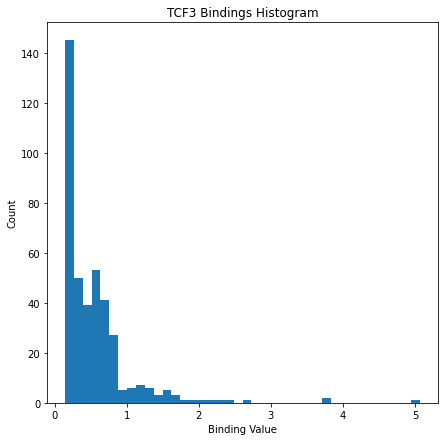

In [13]:
plot_binding_histogram(test_loader, tf)

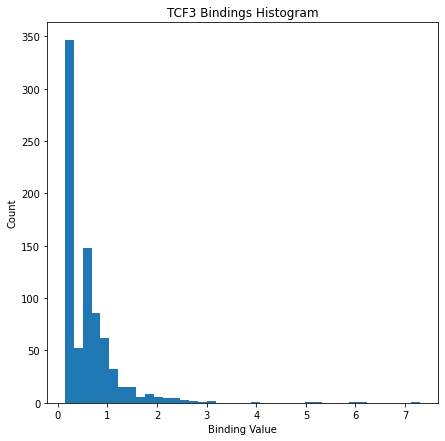

In [14]:
plot_binding_histogram(train_loader, tf)

In [15]:
class BindingPredictionCNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=10, kernel_size=(20, 4), stride=1)
        self.conv2 = Conv1d(in_channels=10, out_channels=20, kernel_size=14, stride=1)
        self.conv3 = Conv1d(in_channels=20, out_channels=30, kernel_size=10, stride=1)

        self.fc1 = Linear(in_features=30*105, out_features=1500)
        self.fc2 = Linear(in_features=1500, out_features=250)
        self.out = Linear(in_features=250, out_features=1)

    def forward(self, x):
        x = F.relu((self.conv1(x)).squeeze())
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [16]:
model = BindingPredictionCNN()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

BindingPredictionCNN(
  (conv1): Conv2d(1, 10, kernel_size=(20, 4), stride=(1, 1))
  (conv2): Conv1d(10, 20, kernel_size=(14,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(10,), stride=(1,))
  (fc1): Linear(in_features=3150, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=250, bias=True)
  (out): Linear(in_features=250, out_features=1, bias=True)
)


In [17]:
def train(net, train_loader, val_loader, optimizer, criterion, epoch_num=100):
    train_log = []
    val_log = []

    for epoch in range(1, epoch_num+1):
        train_loss = []
        net.train()
        for (x, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = net(x)
            loss = criterion(outputs.float(), y.float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_log.append(np.mean(train_loss))
        print('============ epoch %d =============' %epoch)
        print('train loss: %.3f' % np.mean(train_loss), flush=True, end='')

        test_loss = []
        net.eval()
        with torch.no_grad():
            for (x, y) in tqdm(val_loader, desc='Validation ', leave=False):
                x, y = x.to(device), y.to(device)
                outputs = net(x)
                loss = criterion(outputs.float(), y.float())
                test_loss.append(loss.item())
        val_log.append(np.mean(test_loss))
        print('validation loss: %.3f' % np.mean(test_loss), flush=True, end='')
    return train_log, val_log

In [18]:
train_log, val_log = train(model, train_loader, val_loader, optimizer, criterion)

Training epoch 1:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 1 =============
train loss: 0.617

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.547

Training epoch 2:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 2 =============
train loss: 0.467

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.430

Training epoch 3:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 3 =============
train loss: 0.452

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.442

Training epoch 4:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 4 =============
train loss: 0.427

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.417

Training epoch 5:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 5 =============
train loss: 0.416

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.406

Training epoch 6:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 6 =============
train loss: 0.396

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.394

Training epoch 7:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 7 =============
train loss: 0.376

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.393

Training epoch 8:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 8 =============
train loss: 0.370

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.380

Training epoch 9:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 9 =============
train loss: 0.373

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.393

Training epoch 10:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 10 =============
train loss: 0.344

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.363

Training epoch 11:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 11 =============
train loss: 0.311

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.381

Training epoch 12:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 12 =============
train loss: 0.291

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.355

Training epoch 13:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 13 =============
train loss: 0.296

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.482

Training epoch 14:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 14 =============
train loss: 0.294

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.405

Training epoch 15:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 15 =============
train loss: 0.231

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.412

Training epoch 16:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 16 =============
train loss: 0.183

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.441

Training epoch 17:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 17 =============
train loss: 0.151

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.393

Training epoch 18:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 18 =============
train loss: 0.091

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.403

Training epoch 19:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 19 =============
train loss: 0.065

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.405

Training epoch 20:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 20 =============
train loss: 0.046

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.407

Training epoch 21:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 21 =============
train loss: 0.034

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.408

Training epoch 22:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 22 =============
train loss: 0.026

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.402

Training epoch 23:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 23 =============
train loss: 0.020

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.409

Training epoch 24:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 24 =============
train loss: 0.016

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.418

Training epoch 25:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 25 =============
train loss: 0.012

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.413

Training epoch 26:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 26 =============
train loss: 0.009

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.414

Training epoch 27:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 27 =============
train loss: 0.006

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.419

Training epoch 28:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 28 =============
train loss: 0.005

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.417

Training epoch 29:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 29 =============
train loss: 0.004

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.421

Training epoch 30:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 30 =============
train loss: 0.003

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.422

Training epoch 31:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 31 =============
train loss: 0.002

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.421

Training epoch 32:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 32 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.420

Training epoch 33:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 33 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.423

Training epoch 34:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 34 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.422

Training epoch 35:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 35 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 36:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 36 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.423

Training epoch 37:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 37 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.425

Training epoch 38:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 38 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 39:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 39 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 40:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 40 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.425

Training epoch 41:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 41 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 42:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 42 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.425

Training epoch 43:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 43 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 44:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 44 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.425

Training epoch 45:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 45 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 46:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 46 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 47:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 47 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 48:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 48 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 49:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 49 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 50:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 50 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 51:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 51 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 52:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 52 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 53:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 53 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 54:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 54 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 55:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 55 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 56:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 56 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 57:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 57 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 58:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 58 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 59:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 59 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 60:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 60 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 61:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 61 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 62:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 62 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 63:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 63 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 64:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 64 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 65:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 65 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 66:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 66 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 67:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 67 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 68:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 68 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.425

Training epoch 69:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 69 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 70:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 70 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 71:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 71 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 72:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 72 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 73:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 73 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 74:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 74 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 75:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 75 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 76:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 76 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 77:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 77 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 78:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 78 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 79:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 79 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 80:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 80 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 81:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 81 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 82:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 82 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 83:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 83 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 84:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 84 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 85:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 85 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 86:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 86 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.422

Training epoch 87:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 87 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.425

Training epoch 88:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 88 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.422

Training epoch 89:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 89 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.423

Training epoch 90:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 90 =============
train loss: 0.000

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 91:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 91 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.428

Training epoch 92:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 92 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.418

Training epoch 93:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 93 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.423

Training epoch 94:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 94 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.423

Training epoch 95:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 95 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 96:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 96 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.424

Training epoch 97:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 97 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.423

Training epoch 98:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 98 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.422

Training epoch 99:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 99 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.421

Training epoch 100:   0%|          | 0/8 [00:00<?, ?it/s]

============ epoch 100 =============
train loss: 0.001

Validation :   0%|          | 0/2 [00:00<?, ?it/s]

validation loss: 0.421

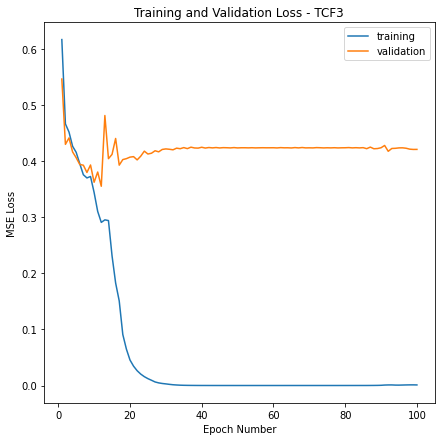

In [19]:
plot_loss(train_log, val_log, 100, tf)

In [20]:
def test(net, test_loader):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():
        for (x_input,labels) in tqdm(test_loader, desc='Test ', leave=False):
            x_input, labels = x_input.to(device), labels.to(device)
            outputs = net(x_input)
            y_true.extend(labels.float().detach().cpu().numpy())
            y_pred.extend(outputs.float().detach().cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

In [21]:
y_true, y_pred = test(model, test_loader)

Test :   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
print("Test MSE: ", mean_squared_error(y_true, y_pred))

Test MSE:  0.2690439


# Classification

In [23]:
binding_values = get_binding_values(train_loader, val_loader)

In [24]:
binding_threshold = np.median(binding_values)

In [25]:
binding_threshold

0.4315965

In [26]:
y_pred_binary = (y_pred > binding_threshold) * 1
y_true_binary = (y_true > binding_threshold) * 1

In [27]:
classification_statistics(y_true_binary, y_pred_binary)

[[107 100]
 [ 81 112]]
              precision    recall  f1-score   support

           0       0.57      0.52      0.54       207
           1       0.53      0.58      0.55       193

    accuracy                           0.55       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.55      0.55      0.55       400

=== Statistics ===
Test Accuracy: 0.547
Test Sensitivity: 0.580
Test Specificity: 0.517
Test F1-Score: 0.553


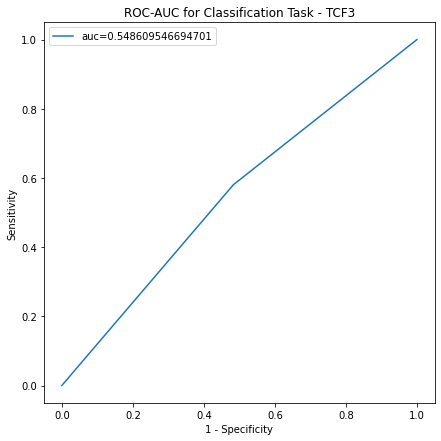

In [29]:
roc_auc_curve_plot(y_true_binary,  y_pred_binary, tf)